In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/RobbieHolland/AIWire.git
%cd AIWire
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# Import libraries 
import time
import matplotlib.pyplot as plt
import numpy as np
# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))


# (Option 1) Generate data
Run the Matlab engine to call scripts that generate data

In [5]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

Engine start took 5.573363304138184 seconds


In [ ]:
data = []

blur = 1.3
im_size = eng.cell2mat([128.0, 64.0])
sim_start = time.time()
for i in range(5):
    eng.addpath('util/')
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    ground_truth, simulated = eng.simulate(pts, im_size, 1.3, 4.0, 1.3, 10.0, 0.2, 1, 0, nargout=2)
    
    plt.subplot(121)
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(122)
    plt.imshow(simulated, cmap='gray')
    plt.show()
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

In [ ]:
from tqdm import tqdm

# Generate data
N = 200
X, y = [], []

for i in tqdm(range(N)):
    ground_truth, simulated = eng.simulate(blur, 15, 0, nargout=2)
    X += [simulated]
    y += [ground_truth]
    
X, y = np.array(X), np.array(y)

# (Option 2) Load data
Load data saved in a <tt>.mat</tt> file

In [6]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
X, y = load_data('.', 'data/iteration_1_dataset')

In [7]:
import dataset
from sklearn.model_selection import train_test_split

batch_size = 50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

{'train': 1600, 'val': 400}


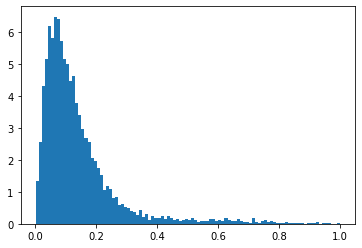

In [8]:
# Look at statistics of data
h2 = plt.hist(X_train[0].reshape(-1,1), bins = 100, density = True, alpha=1)

# Intensity-based Segmentation
Here, we use a Laplace filter to do a basic intensity based segmentation

In [25]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2

# The background and the wire
n_components = 2

# model=GaussianMixture(n_components=n_components, means_init=[[0], [0.6]])
# model.fit(X, y)

def laplace_segmentation(image):
    lp = -cv2.Laplacian(image, cv2.CV_64F, ksize=15)
    lp = lp - np.min(lp)
    lp = lp / np.max(lp)
    return lp
    
segmentations_laplace, segmentations_threshold = [], []
for datum in X_test:
        
    # Threshold segmentation
    segmentations_threshold += [datum > 0.45]
    
    # Laplace filter
    segmentations_laplace += [laplace_segmentation(datum)]
#     segmentations_edge += [cv2.Sobel(datum,cv2.CV_64F,1,0,ksize=5)]


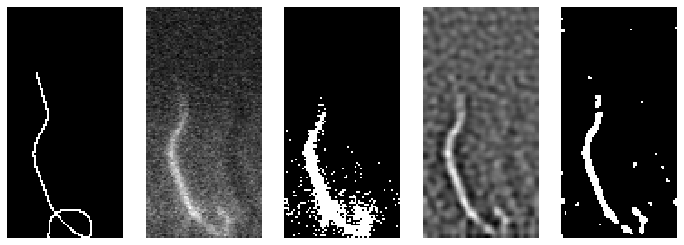

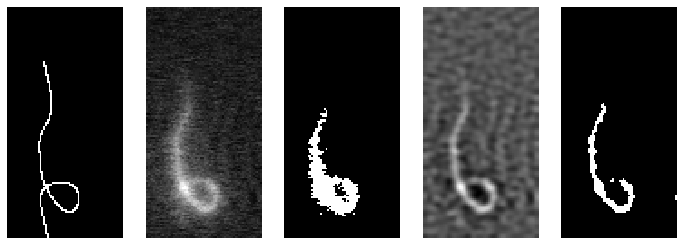

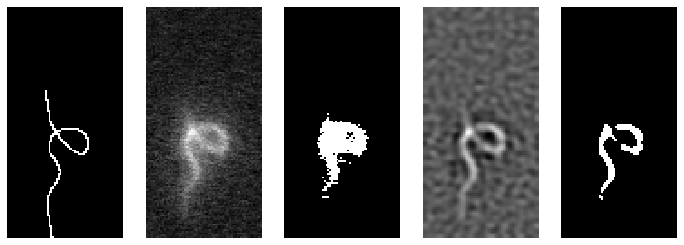

In [26]:
# Show first few segmentations
for i, (seg_lap, seg_thresh, ground_truth, simulated) in enumerate(list(zip(segmentations_laplace, segmentations_threshold, y_test, X_test))[:3]):
    plt.figure(figsize=(12, 12))
    plt.subplot(151)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(simulated, cmap='gray')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(seg_thresh, cmap='gray')
    plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(seg_lap, cmap='gray')
    plt.axis('off')
    
    plt.subplot(155)
    plt.imshow(seg_lap > 0.52, cmap='gray')
    plt.axis('off')


# Random Forest Segmentation
This is the first machine learning method we are using.

### Create the dataset
Random forests predict each patch of the image by taking as input a larger, surrounding patch (to capture context)<br>
Thus, <br>
<b>y</b>: Patches of the image <br>
<b>X</b>: Larger patches centered over each <b>y</b>

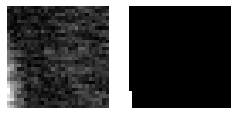

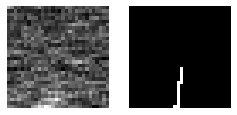

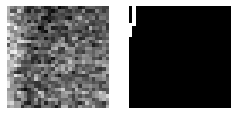

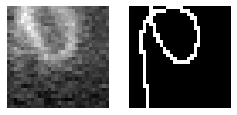

In [28]:
from random import randint

n_patches = 3000
patch_dim = 30
patches_sim, patches_gt = [], []
for i in range(n_patches):
    sample_train = X_train[i % len(X_train)]
    sample_test  = y_train[i % len(y_train)]
    tl = np.array([randint(0, sample_train.shape[i] - patch_dim - 1) for i in [0, 1]])
    patches_sim.append(sample_train[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])
    patches_gt.append(sample_test[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])

for i, (patch_sim, patch_gt) in enumerate(list(zip(patches_sim, patches_gt))[:4]):
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(patch_sim, cmap='gray')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(patch_gt, cmap='gray')
    plt.axis('off')
    
patches_sim, patches_gt = np.array(patches_sim), np.array(patches_gt)
w = 3
c = patch_dim // 2
patch_labels = np.array([p[c - w:c + w, c - w:c + w] for p in patches_gt])
X_patches = np.array(patches_sim).reshape(n_patches,-1)
y_patches = np.array(patch_labels).reshape(n_patches,-1)

### Train random forest classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print('Class balance: ', np.sum(patch_labels) / np.prod(patch_labels.shape))
clf = RandomForestClassifier(max_depth=100)

X_patches_train, X_patches_test, y_patches_test, y_patches_train = train_test_split(X_patches, y_patches, test_size=0.15, random_state=0)

clf.fit(X_patches_train, y_patches_test)
preds = clf.predict(X_patches_test)

Class balance:  0.032601851851851854


/Users/Robert/Documents/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Make prediction on image
To actually segment an image, we must do so patch-by-patch<br>
Then collect the patches into the final segmentation

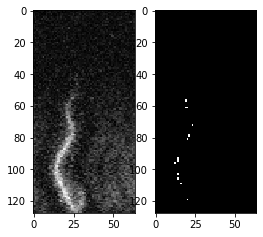

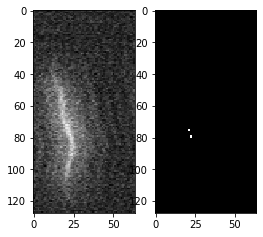

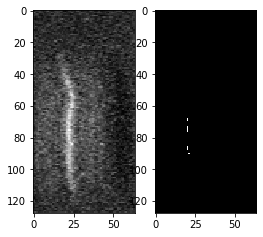

In [32]:
def rf_segmentation(image):
    test_sample = np.array(image)
    sample = np.pad(test_sample, patch_dim // 2 - w, mode='reflect')
    
    total_pred = np.zeros_like(test_sample)
    for i in range(w, test_sample.shape[0] - 2*w, 2 * w):
        for j in range(w, test_sample.shape[1] - 2*w, 2 * w):
            patch = sample[i:i + patch_dim, j:j + patch_dim]
            pred = clf.predict(patch.reshape(1,-1))

            total_pred[i-w:i+w,j-w:j+w] = pred.reshape(6,6)
    return total_pred

for i in range(3):
    pred = rf_segmentation(X[i])
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(X[i], cmap='gray')
    plt.subplot(122)
    plt.imshow(pred, cmap='gray')

# Evaluation
pts, im_size, blur, thickness, ...
   undersampling, undersampling_spread, tip_current, length_regression, verbose

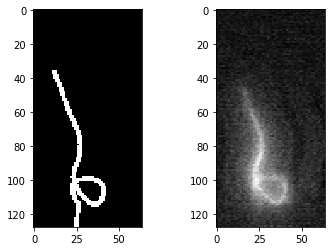

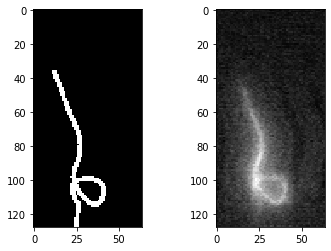

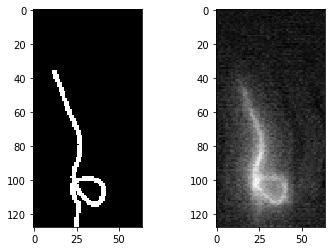

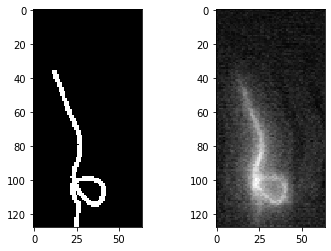

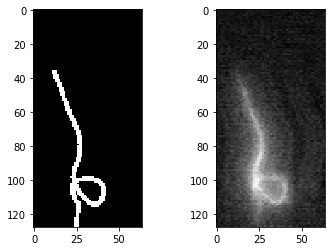

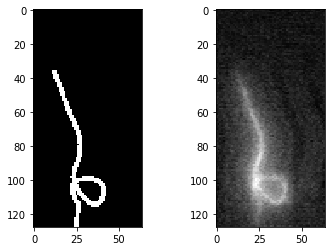

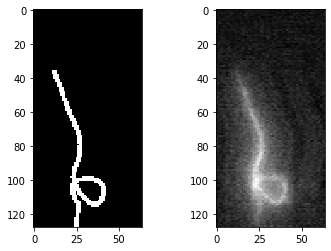

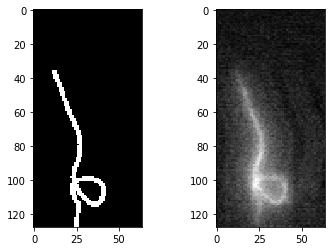

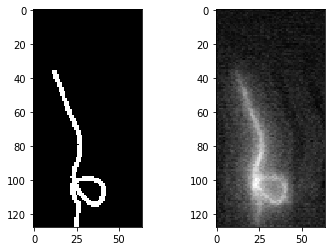

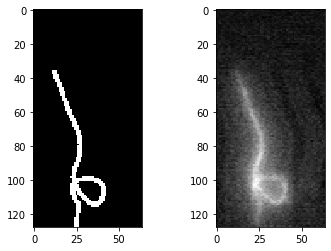

Simulation took 6.369041204452515 seconds


In [41]:
n_values = 10
im_size = eng.cell2mat([128.0, 64.0])
loop_prob = 0.75
eng.addpath('util/')
pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)

blur = [1.3] * n_values
undersampling = [1.3] * n_values
undersampling_spread = [10.0] * n_values
# tip_current = [0.2] * n_values
tip_current = np.linspace(0, 1, num=n_values).tolist()

sim_start = time.time()
for b, u, us, tc in zip(blur, undersampling, undersampling_spread, tip_current):
    eng.rng(1234)
    ground_truth, simulated = eng.simulate(pts, im_size, b, 3.0, u, us, tc, 0, 0, nargout=2)
    
    plt.subplot(121)
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(122)
    plt.imshow(simulated, cmap='gray')
    plt.show()
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')